# DenseNet
Verilerimizi DenseNet'in 4 versiyonu ile eğiticez.
- DenseNet 121
- DenseNet 201
- DenseNet 161
- DenseNet 169

#### Google Colab Doğrulama

3 tane datasetimiz var. Onlara ulaşabilmek adına doğrulama işlemlerini gerçekleştiriyoruz.


In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Bağlanıp bağlanmadığımız görmek amacıyla drive daki çalışma alanımızın içindekileri listele komutunu çalıştırıyoruz.

In [3]:
ls "/content/drive/My Drive/CT"

checkpoint    denseNet_model_78.h5               my_model_fra.h5  transfer/
covid/        earlystop_model.h5                 non-covid/       works/
COVID/        model.h5                           NonCOVID/
CT_COVID/     model_weights.data-00000-of-00001  Normalize/
CT_NonCOVID/  model_weights.index                saved_models/


#### Kütüphaneler

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121, MobileNetV2


from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping

Normalize edilmiş değerleri önceki ipynb dosyamızda npy olarak kaydetmiştik. Bu aşama, işlemlerimizi hızlandırmak için yapıldı. numpy kütüphanesinden load() metodunu çağırarak normalize olmuş datamızı kullanmaya başlayabiliriz.

In [33]:
a= "/content/drive/My Drive/CT/Normalize/"

#300 veri bulunan dataset
l1x=a+ "X_nparray300.npy"
l1y=a+ "y_nparray300.npy"

#1200 veri bulunan dataset
l2x=a+ "X_nparray1200.npy"
l2y=a+ "y_nparray1200.npy"

#3000 veri bulunan dataset
l3x=a+ "X_nparray3000.npy"
l3y=a+ "y_nparray3000.npy"

loaded_array_x1200 = np.load(l2x)
loaded_array_y1200 = np.load(l2y)

In [34]:
X=loaded_array_x1200
y=loaded_array_y1200

Datamızın doğru yüklendiğine emin olmak için shape metodunu kullanarak inceliyoruz.

In [35]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2481, 64, 64, 3) and shape of target variable: (2481, 2)


Verisetimiz üzerinde kaç tane forward ve backward propagation yapılacağını ayarladığımız apoch sayımızı 50,100 ve 200 vereceğiz.

Tüm veri kümesini aynı anda sinir ağına veremeyeceğimiz için dataseti parçalara böleriz. Yani batch size olarak adlandırdığımız bu hiperparametre üzerinde çalışılacak bir parti örneğin miktarını bize söyler. Burada 64'er adet image lar halinde modelimize göndereceğiz.

In [36]:
EPOCHS = 50
# 50, 100, 200
SIZE=64
N_ch=3
BATCH_SIZE = 64
SEED= 42

IMG_W= 64
IMG_H= 64
CHANNELS = 3

INPUT_SHAPE=(IMG_W, IMG_H, CHANNELS)

# DenseNet 121

In [37]:
def build_densenet121():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [38]:
model=build_densenet121()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)


In [40]:
len(X_train)

1736

In [41]:
len(X_val)

745

In [42]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [43]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))



        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
27/27 - 15s - loss: 1.2649 - accuracy: 0.5197 - val_loss: 2.6958 - val_accuracy: 0.5007

Epoch 00001: val_loss improved from inf to 2.69585, saving model to model_CNN2.h5
Epoch 2/50
27/27 - 3s - loss: 1.0287 - accuracy: 0.5813 - val_loss: 2.5266 - val_accuracy: 0.4980

Epoch 00002: val_loss improved from 2.69585 to 2.52656, saving model to model_CNN2.h5
Epoch 3/50
27/27 - 3s - loss: 0.9171 - accuracy: 0.6274 - val_loss: 1.4689 - val_accuracy: 0.5450

Epoch 00003: val_loss improved from 2.52656 to 1.46890, saving model to model_CNN2.h5
Epoch 4/50
27/27 - 3s - loss: 0.8038 - accuracy: 0.6746 - val_loss: 1.0998 - val_accuracy: 0.5664

Epoch 00004: val_loss improved from 1.46890 to 1.09981, saving model to model_CNN2.h5
Epoch 5/50
27/27 - 3s - loss: 0.7248 - accuracy: 0.7099 - val_loss: 1.2080 - val_accuracy: 0.5691

Epoch 00005: val_loss did not improve from 1.09981
Epoch 6/50
27/27 - 3s - loss: 0.7191 - accuracy: 0.6884 - val_loss: 1.4951 - val_accuracy: 0.5530

Epoch 00006: v

In [44]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.894138753414154
validation_accuracy =  0.5355704426765442
training_loss   =  0.25817418098449707
validation_loss =  1.777127981185913


## Accuracy ve Loss değerlerinin görselleştirilmeleri

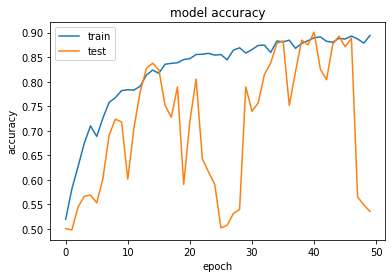

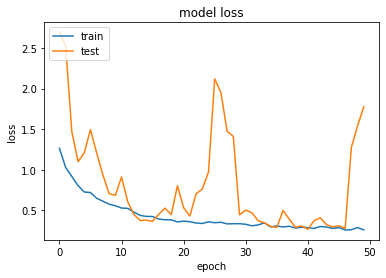

In [45]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sonuçlar

**Accuracy**:
**Precision**: Yanlış Pozitifin maliyetinin ne kadar yüksek olduğunu belirlemek için kullanılır.<br>
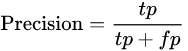 <br>
**Recall**: Pozitif olarak etiketleyerek kaç tane Gerçek Pozitif yakalandığını hesaplar.<br>
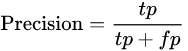<br>

**F1-score**: Hassasiyet(Precision) ve Recall'un ağırlıklı ortalamasıdır.<br>
F1 = 2 × (precision × recall) / (precision + recall)

**Cohen's Kappa**:

**ROC AUC**: ROC eğrisinin altında kalan alan olan AUC tahminler doğrulaştıkça 1 noktasına doğru gitme eğilimindedir.

**R2**:

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.535570
Precision: 1.000000
Recall: 0.067385
F1 score: 0.126263
Cohens kappa: 0.067638
ROC AUC: 0.533693
Precision =  1.000
[[374   0]
 [346  25]]


In [47]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: -0.6118 MSE: 0.4029
Test R2 Score:   -0.6310 MSE: 0.4077


### Karmaşıklık Matrisi

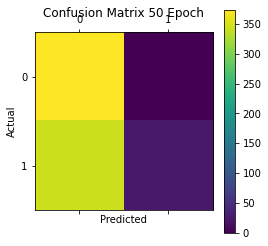

In [49]:
plt.matshow(cf)
plt.title('Confusion Matrix 50 Epoch')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

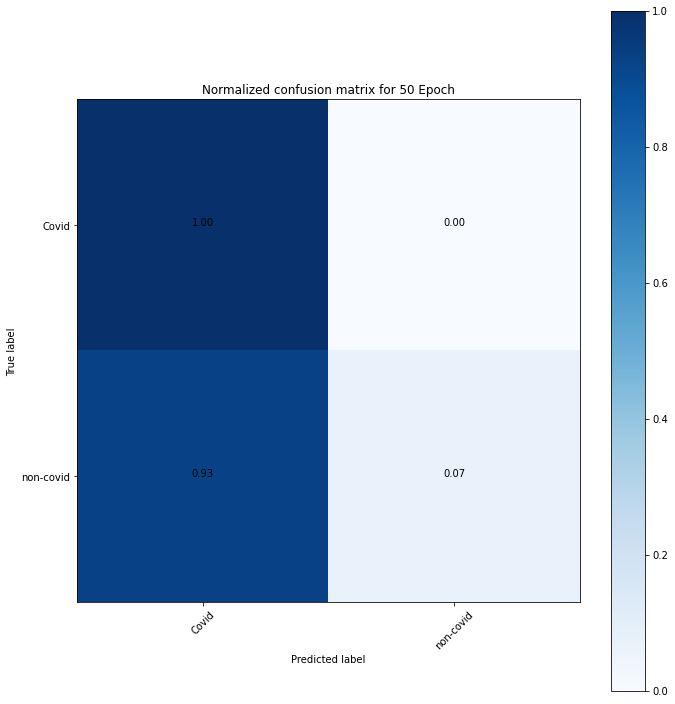

In [50]:


class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix for 50 Epoch')
plt.show()

#### ROC AUC Score

roc_auc_score for Model:  0.5336927223719676


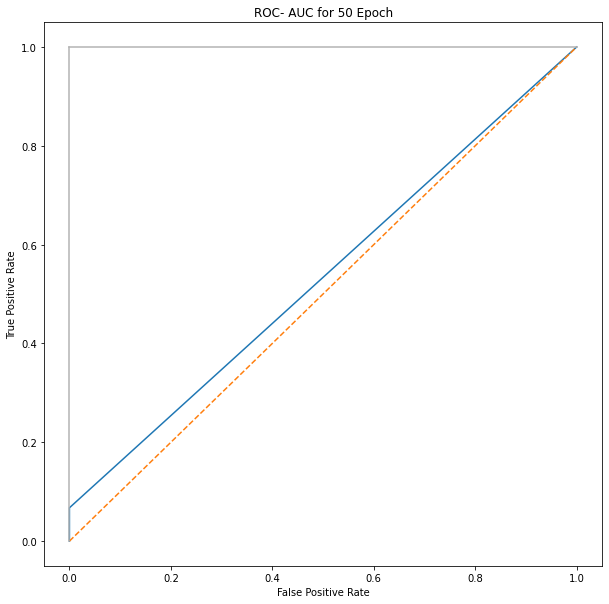

In [52]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC- AUC for 50 Epoch')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# epoch=100

In [53]:
EPOCHS = 100



In [54]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 3s - loss: 0.2588 - accuracy: 0.8889 - val_loss: 1.9309 - val_accuracy: 0.5289

Epoch 00001: val_loss improved from inf to 1.93090, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 3s - loss: 0.2701 - accuracy: 0.8941 - val_loss: 1.1331 - val_accuracy: 0.6201

Epoch 00002: val_loss improved from 1.93090 to 1.13313, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 3s - loss: 0.2808 - accuracy: 0.8774 - val_loss: 0.5285 - val_accuracy: 0.7168

Epoch 00003: val_loss improved from 1.13313 to 0.52855, saving model to model_CNN2.h5
Epoch 4/100
27/27 - 3s - loss: 0.2719 - accuracy: 0.8852 - val_loss: 0.2844 - val_accuracy: 0.8953

Epoch 00004: val_loss improved from 0.52855 to 0.28441, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 3s - loss: 0.2667 - accuracy: 0.8906 - val_loss: 0.2649 - val_accuracy: 0.9020

Epoch 00005: val_loss improved from 0.28441 to 0.26494, saving model to model_CNN2.h5
Epoch 6/100
27/27 - 3s - loss: 0.2590 - accuracy: 0.8929 - val_loss: 0.494

In [55]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.9443780183792114
validation_accuracy =  0.908724844455719
training_loss   =  0.13798774778842926
validation_loss =  0.2127104252576828


# Görselleştirme

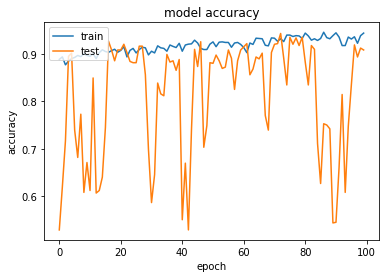

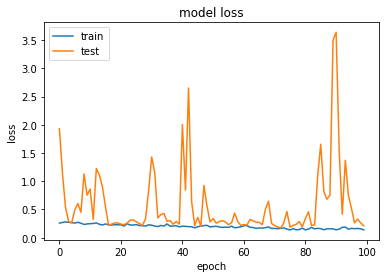

In [56]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Metriklere göre Sonuçlar

In [57]:
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.908725
Precision: 0.929178
Recall: 0.884097
F1 score: 0.906077
Cohens kappa: 0.817411
ROC AUC: 0.908626
Precision =  0.929
[[349  25]
 [ 43 328]]


# R2 MSE

In [58]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.8587 MSE: 0.0353
Test R2 Score:    0.7601 MSE: 0.0600


# Confusion Matrix

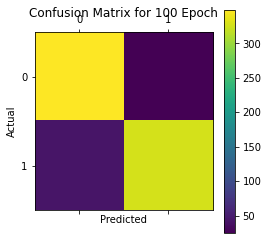

In [60]:
plt.matshow(cf)
plt.title('Confusion Matrix for 100 Epoch')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

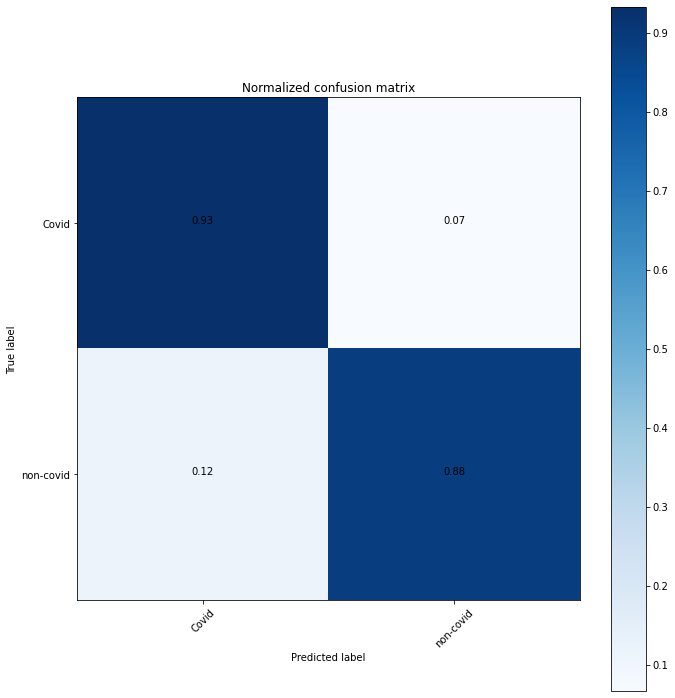

In [61]:

class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix for 100 Epoch', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# ROC AUC Score

roc_auc_score for Model:  0.9086260576271674


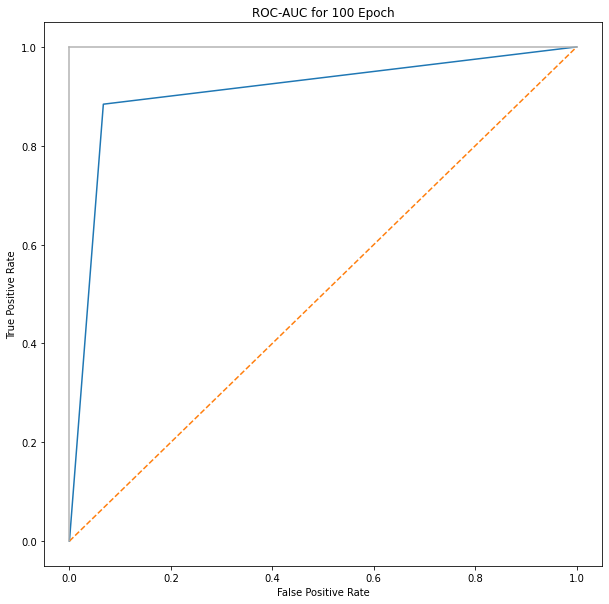

In [63]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC-AUC for 100 Epoch')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# Epoch=200

In [64]:
EPOCHS = 200

In [66]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))
               
               

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
27/27 - 3s - loss: 0.0513 - accuracy: 0.9821 - val_loss: 0.2686 - val_accuracy: 0.9248

Epoch 00001: val_loss improved from inf to 0.26861, saving model to model_CNN2.h5
Epoch 2/200
27/27 - 3s - loss: 0.1439 - accuracy: 0.9468 - val_loss: 0.4385 - val_accuracy: 0.8577

Epoch 00002: val_loss did not improve from 0.26861
Epoch 3/200
27/27 - 3s - loss: 0.0957 - accuracy: 0.9605 - val_loss: 0.1523 - val_accuracy: 0.9503

Epoch 00003: val_loss improved from 0.26861 to 0.15228, saving model to model_CNN2.h5
Epoch 4/200
27/27 - 3s - loss: 0.0613 - accuracy: 0.9785 - val_loss: 0.4300 - val_accuracy: 0.8497

Epoch 00004: val_loss did not improve from 0.15228
Epoch 5/200
27/27 - 3s - loss: 0.0711 - accuracy: 0.9749 - val_loss: 0.2051 - val_accuracy: 0.9342

Epoch 00005: val_loss did not improve from 0.15228
Epoch 6/200
27/27 - 3s - loss: 0.0691 - accuracy: 0.9707 - val_loss: 0.1541 - val_accuracy: 0.9517

Epoch 00006: val_loss did not improve from 0.15228
Epoch 7/200
27/27 - 3s - los

In [67]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.9814593195915222
validation_accuracy =  0.8536912798881531
training_loss   =  0.05929458513855934
validation_loss =  0.44270098209381104


# Görselleştirme

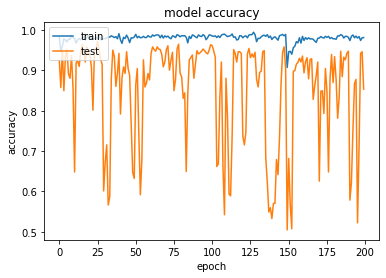

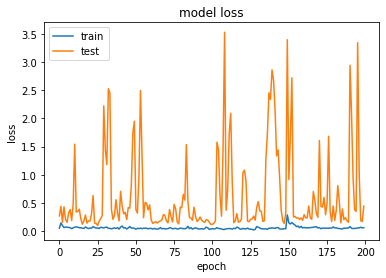

In [68]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Metriklere göre Sonuçlar

In [69]:
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.853691
Precision: 0.951724
Recall: 0.743935
F1 score: 0.835098
Cohens kappa: 0.707121
ROC AUC: 0.853251
Precision =  0.952
[[360  14]
 [ 95 276]]


# R2 MSE

In [70]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")



Train R2 Score: 0.6016 MSE: 0.0996
Test R2 Score:    0.5381 MSE: 0.1155


# Confusion Matrix

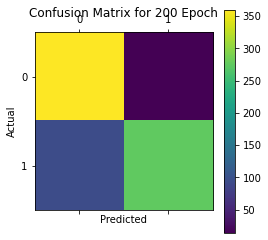

In [72]:
plt.matshow(cf)
plt.title('Confusion Matrix for 200 Epoch')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

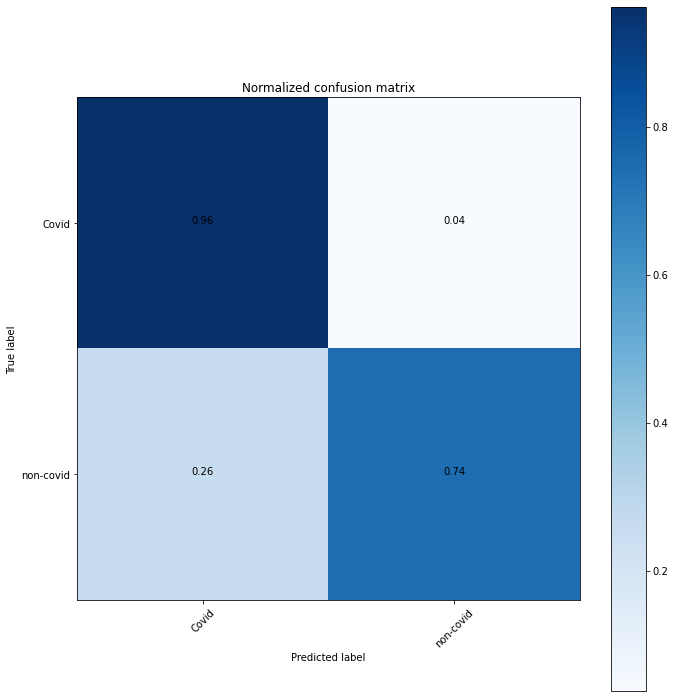

In [73]:
class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix for 200 Epoch', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# ROC AUC Score

roc_auc_score for Model:  0.8532510774464159


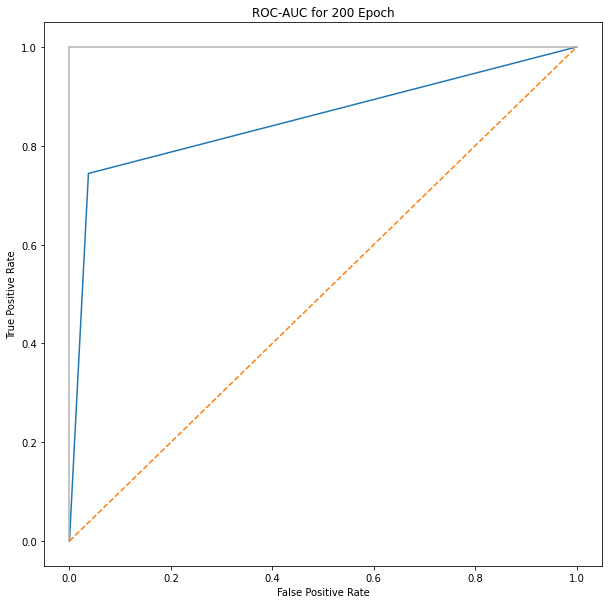

In [75]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC-AUC for 200 Epoch')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# Conclusion

# EPOCH KARŞILAŞTIRMA
*Sonuçlar*


```
××××××××××××××××××××××××××××××××××××××××××××××××× EPOCHS=50
training_accuracy   =  0.894138753414154
validation_accuracy =  0.5355704426765442
training_loss   =  0.25817418098449707
validation_loss =  1.777127981185913
 
Accuracy: 0.535570
Precision: 1.000000
Recall: 0.067385
F1 score: 0.126263
Cohens kappa: 0.067638
ROC AUC: 0.533693
Precision =  1.000
[[374   0]
 [346  25]]
 
 
Train R2 Score: -0.6118 MSE: 0.4029
Test R2 Score:   -0.6310 MSE: 0.4077
 
××××××××××××××××××××××××××××××××××××××××××××××××× EPOCHS=100
training_accuracy   =  0.9443780183792114
validation_accuracy =  0.908724844455719
training_loss   =  0.13798774778842926
validation_loss =  0.2127104252576828
 
Accuracy: 0.908725
Precision: 0.929178
Recall: 0.884097
F1 score: 0.906077
Cohens kappa: 0.817411
ROC AUC: 0.908626
Precision =  0.929
[[349  25]
 [ 43 328]]
 
Train R2 Score: 0.8587 MSE: 0.0353
Test R2 Score:    0.7601 MSE: 0.0600
 
××××××××××××××××××××××××××××××××××××××××××××××××× EPOCHS=200

training_accuracy   =  0.9814593195915222
validation_accuracy =  0.8536912798881531
training_loss   =  0.05929458513855934
validation_loss =  0.44270098209381104

Accuracy: 0.853691
Precision: 0.951724
Recall: 0.743935
F1 score: 0.835098
Cohens kappa: 0.707121
ROC AUC: 0.853251
Precision =  0.952
[[360  14]
 [ 95 276]]
 
Train R2 Score: 0.6016 MSE: 0.0996
Test R2 Score:    0.5381 MSE: 0.1155



```




# 50 Epoch
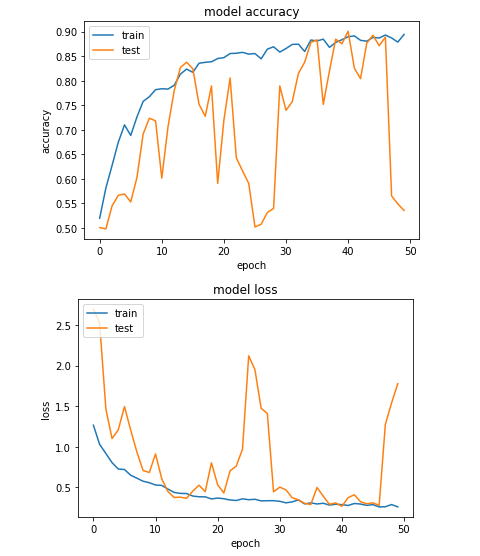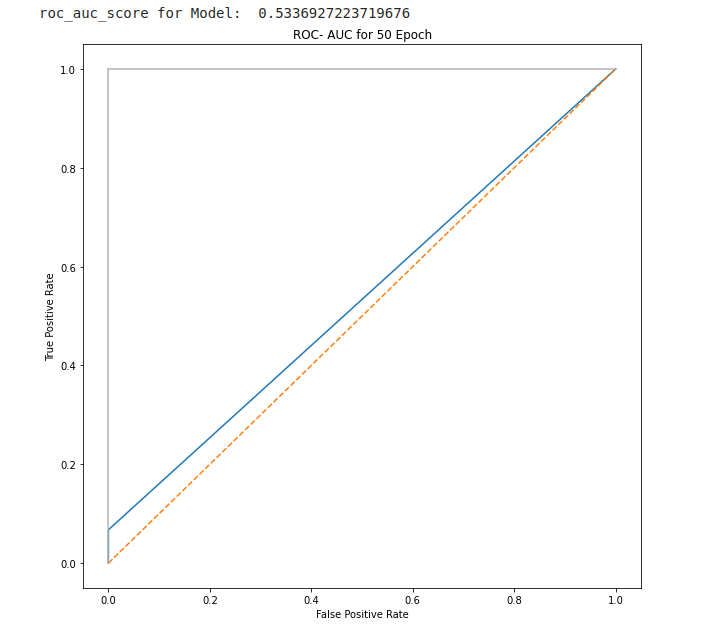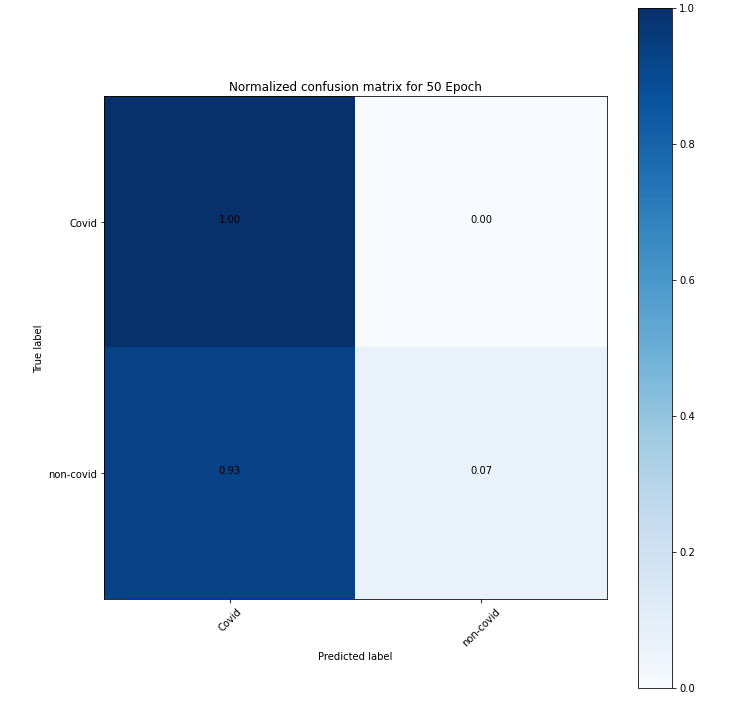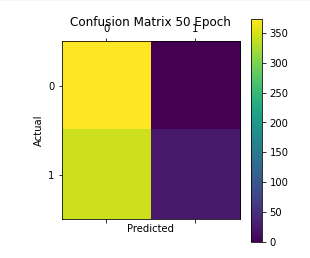

# 100 Epoch
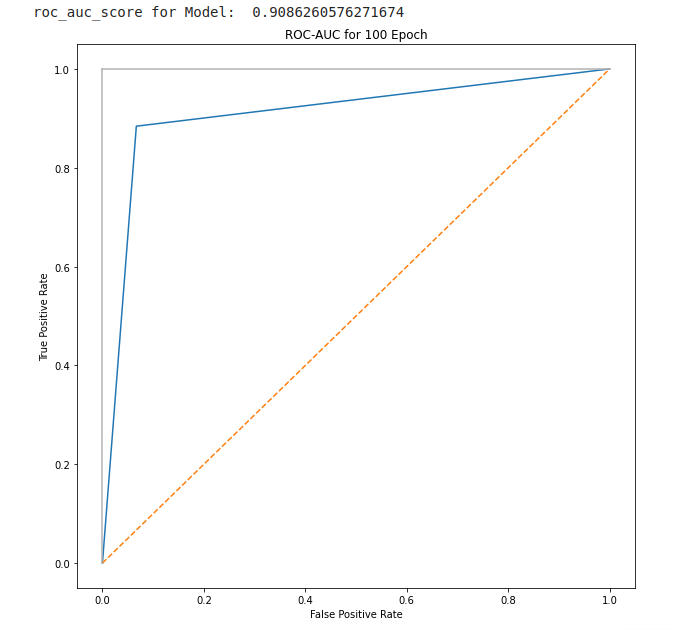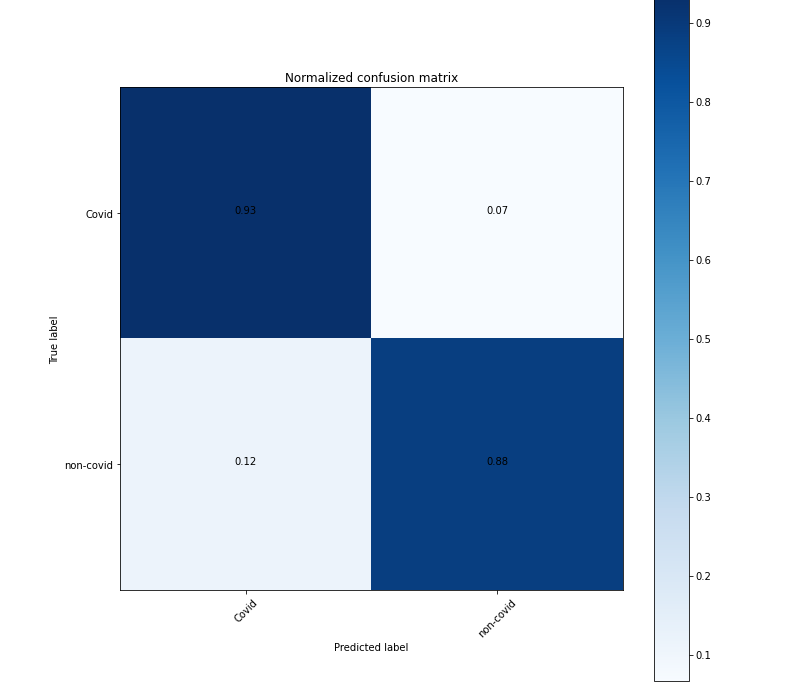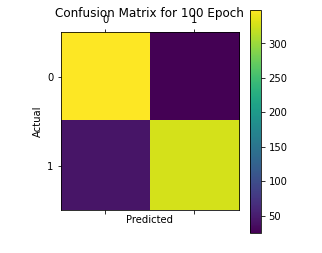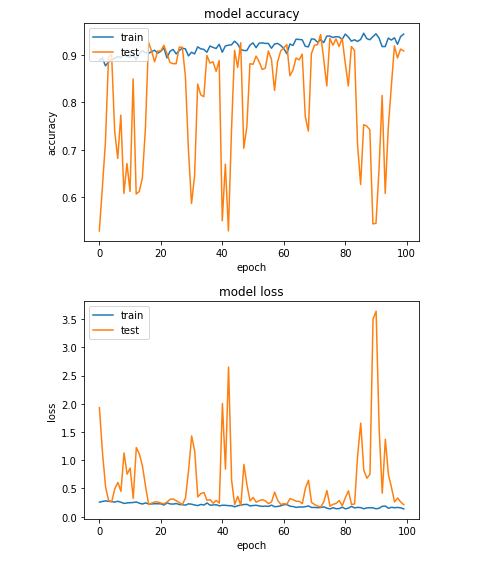

# 200 Epoch
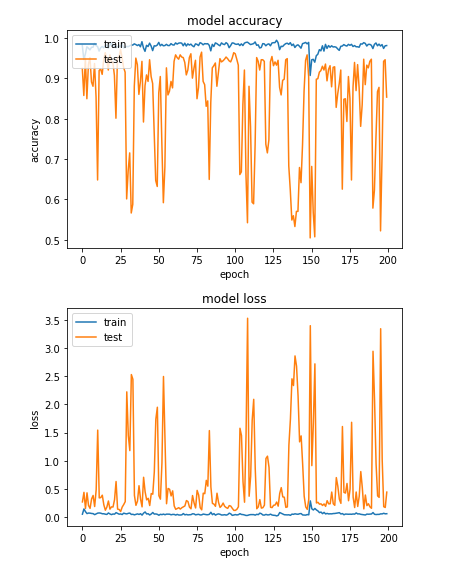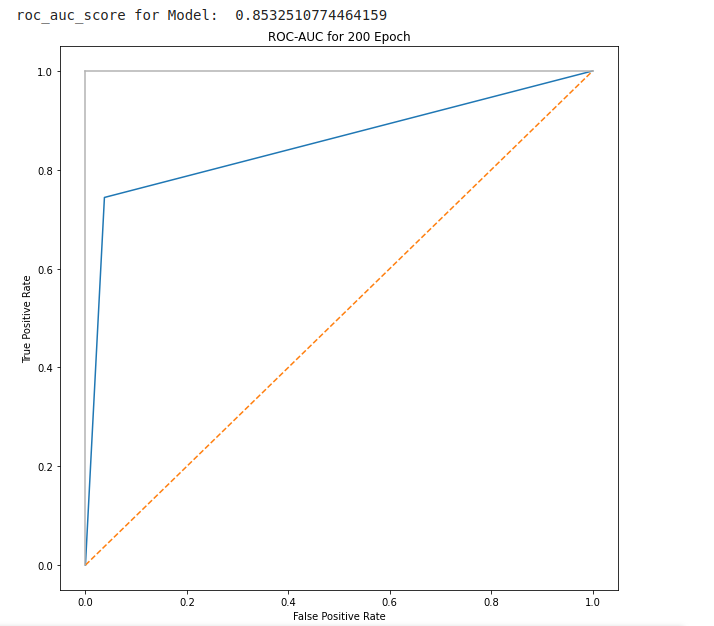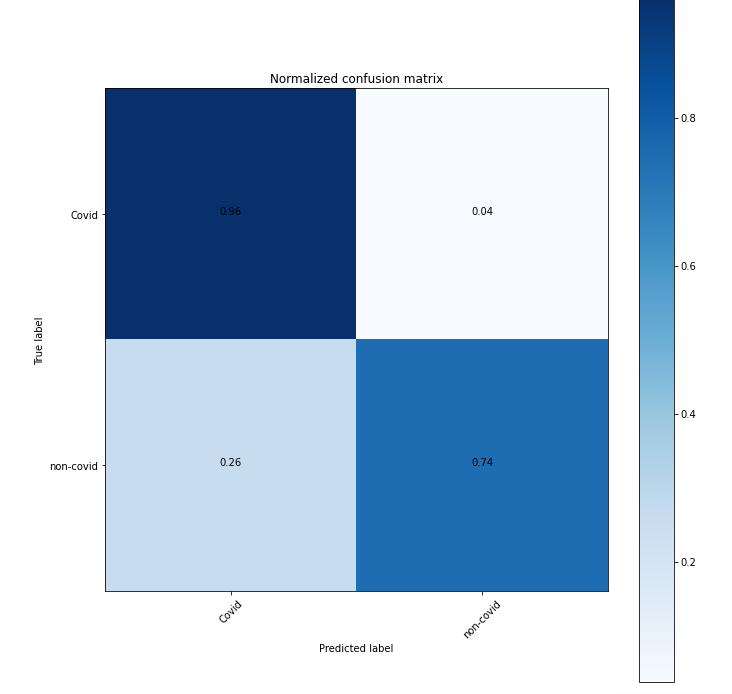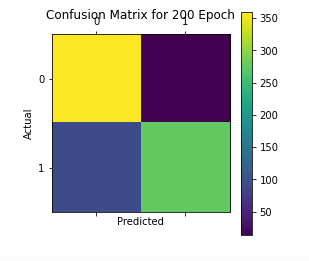

08.01.2021 15.06

Fatma Zehra